In [9]:
import numpy as np
np.random.seed(1337)  # for reproducibility
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Опрос в начале лекции:
https://forms.gle/cNRwS15sfJG9yADx6

# План занятия:
- нейронные сети обзор,
- алгоритм обратного распространения ошибки,
- стохастический градиентный спуск для оптимизации функции потерь,
- GPU и нейронные сети,
- нейронные сети in action: pytorch vs tensorflow vs keras
- примеры задач, решаемых нейронными сетями

### Нейронная сеть

Рассмотрим задачу бинарной классификации. Все объекты в тренировочной выборке отмечены $1$ и $0$  

Каждый вход - вектор вещественных чисел $\boldsymbol{x} = (1, x_1, x_2, ..., x_d) \in \mathbb{R}^d$.  
Каждый вход отмечен известной меткой - выходом $y(\boldsymbol{x})= {0, 1}$

Будем искать такие веса $w_0, w_1, ..., w_d \in \mathbb{R}^d$, чтобы минимизировать перекрестную энтропию:

$$E(\boldsymbol{w}) = - \frac{1}{N}\sum_{i=1}^{N}(y_i log \sigma(\boldsymbol{w}^T \boldsymbol{x}_i) + (1 - y_i)log (1 - \sigma(\boldsymbol{w}^T\boldsymbol{x}_i))),$$

где $\sigma(x) = \frac{1}{1 + e ^{-x}}$ - функция активации. 


Оптимизируем градиентным спуском.


Один перцептрон - это разновидность линейной регресии. Разные нелинейности на выходе нейрона можно рассматривать как разные формы функции ошибки.



<img src='neuron.png'>


Линейная комбинация входов, потом нелинейность
$$y = h(\boldsymbol{w}^T\boldsymbol{x})= h(\sum_{i}w_i x_i)$$

### Обратное распространение ошибки
Выход одного нейрона:
$$o_{j}=\varphi\left(\text { net }_{j}\right)=\varphi\left(\sum_{k=1}^{n} w_{k j} o_{k}\right)$$

В качестве функции активации будем рассматривать сигмоиду (также стоит посмотреть ReLU, tanh)
$$\varphi(z)=\frac{1}{1+e^{-z}}$$

Производная сигмоиды имеет вид:
$$\frac{d \varphi(z)}{d z}=\varphi(z)(1-\varphi(z))$$

Для того, чтобы свести задачу к оптимизационной нужно научиться рассчитывать градиент функции потерь по весам нейронной сети:
$$\frac{\partial E}{\partial w_{i j}}=\frac{\partial E}{\partial o_{j}} \frac{\partial o_{j}}{\partial w_{i j}}=\frac{\partial E}{\partial o_{j}} \frac{\partial o_{j}}{\partial т_{j}} \frac{\partial n_{j}}{\partial w_{i j}}$$

В последней части выражения только один $n_j$ от $w_{i j}$.
$$\frac{\partial n_{j}}{\partial w_{i j}}=\frac{\partial}{\partial w_{i j}}\left(\sum_{k=1}^{n} w_{k j} o_{k}\right)=\frac{\partial}{\partial w_{i j}} w_{i j} o_{i}=o_{i}$$

$$\frac{\partial E}{\partial o_{j}}=\sum_{\ell \in L}\left(\frac{\partial E}{\partial \text { net }_{\ell}} \frac{\partial \text { net }_{\ell}}{\partial o_{j}}\right)=\sum_{\ell \in L}\left(\frac{\partial E}{\partial o_{\ell}} \frac{\partial o_{\ell}}{\partial \text { net }_{\ell}} \frac{\partial \text { net }_{\ell}}{\partial o_{j}}\right)=\sum_{\ell \in L}\left(\frac{\partial E}{\partial o_{\ell}} \frac{\partial o_{\ell}}{\partial \text { net }_{\ell}} w_{j \ell}\right)$$

Итого получаем:

$$\frac{\partial E}{\partial w_{i j}}=\frac{\partial E}{\partial o_{j}} \frac{\partial o_{j}}{\partial n e t_{j}} \frac{\partial n e t_{j}}{\partial w_{i j}}=\frac{\partial E}{\partial o_{j}} \frac{\partial o_{j}}{\partial n e t_{j}} o_{i}$$

$$\frac{\partial E}{\partial w_{i j}}=o_{i} \delta_{j}$$

$$\delta_{j}=\frac{\partial E}{\partial o_{j}} \frac{\partial o_{j}}{\partial \text { net }_{j}}$$

### Визуализация back-propagation

https://google-developers.appspot.com/machine-learning/crash-course/backprop-scroll/

### Граф вычислений и дифференцирование

Рассмотрим функцию $$x^2 + xy + (x + y)^2$$

Ее можно представить в виде графа несколькими способами (как композицию простых функций):

<img src='graph.png'>

Дифференцирование. Пользуемся правилом дифференцирования сложной функции.

$$(f\circ g)\prime(x) = (f(g(x)))\prime = f\prime(g(x))g\prime(x)$$

Если дифференцируем по векторам - получаем градиент, а если по матрице - получаем матрицу Якоби.

<img src='g1.png'>

Forward propagation (прямое распространение). Вычисляем $\frac{\delta f}{\delta x} $ как сложную функцию

<img src='g2.png'>

Back propagation (обратное распространение). Начинаем от конца и идем как  $\frac{\delta f}{\delta g} = \sum_{g \prime \in Children(g)} \frac{\delta f}{\delta g \prime} \frac{\delta g \prime}{\delta g } $ 

<img src='g3.png'>

Разбор примера см в [1]

In [ ]:
z = 1/(1 + np.exp(-np.dot(W, x))) # forward pass
dx = np.dot(W.T, z*(1-z)) # backward pass: local gradient for x
dW = np.outer(z*(1-z), x) # backward pass: local gradient for W

### Проблемы данного подхода:
- vanishing gradients
при неаккуратно инициализации или препроцессинге данных градиенты могут сильно уменьшиться (см. производную сигмоиды)

### Стохастический градиентный спуск для оптимизации функции потерь

- для оптимизации функции потерь далее можно использовать стохастический градиентный спуск и методы, рассмотренные в занятиях по оптимизации функций,

<img src='grad.png'>

#### Градиентный спуск

```{python}
1.function gd(X, alpha, epsilon):
2.    initialise theta 
3.    do: 
4.        theta = new_theta
5.        new_theta = theta - alpha * grad(X, theta)
6.    until dist(new_theta, theta) < epsilon
7.    return theta
```

#### Стохастический градиентный спуск

```{python}
1.function sgd(X, alpha, epsilon):
2. 	initialise theta 
3. 	do: 
4.        X = shuffle(X)
5.        for x in X:
6.            theta = new_theta
7.            new_theta = theta - alpha * grad(x, theta)
8.	until dist(new_theta, theta) < epsilon
9.	return theta
```

# Нейронные сети in Action

## Современные фреймворки
### tensorflow
- разработан google
- использует статический вычислительный граф
- хорошо подходит для продакшен разработки, переноса кода на другие платформы

### pytorch
- разработан facebook
- использует динамический вычислительный граф
- подходит для прототипирования, небольших моделей

### keras
- high level api над мощными библиотеками машинного обучения: tensorflow, cntk или theano
- удобно использовать для быстрого прототипирования
- хорошо читаемый код моделей
- низкий порог входа

### Github statistics:
torch: 7,235 + (py) 25,019  
tensorflow: 63,330  
keras: 25,222  

### Пример датасет MNIST:

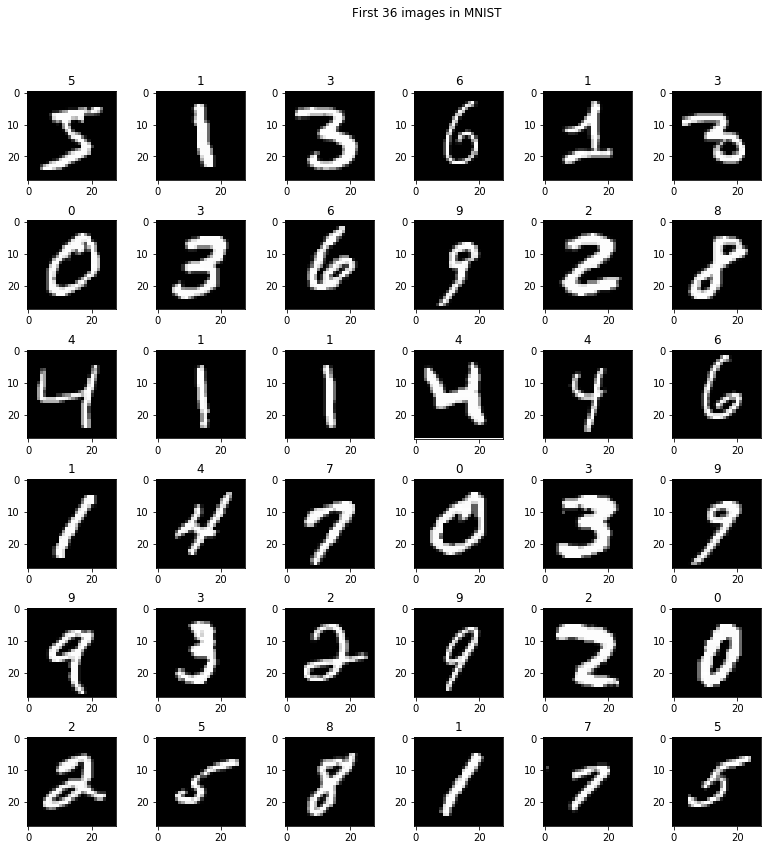

In [13]:
# plot first 36 images in MNIST
fig, ax = plt.subplots(6, 6, figsize = (12, 12))
fig.suptitle('First 36 images in MNIST')
fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
for x, y in [(i, j) for i in range(6) for j in range(6)]:
    ax[x, y].imshow(X_train[x + y * 6].reshape((28, 28)), cmap = 'gray')
    ax[x, y].set_title(y_train[x + y * 6])

####  Сверточные нейронные сети
<img src="conv_nn.png">

## Keras

In [14]:
batch_size = 128
nb_classes = 10
nb_epoch = 12

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

In [15]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [16]:
X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
input_shape = (1, img_rows, img_cols)

In [17]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


In [18]:
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [19]:
print(input_shape)

(1, 28, 28)


In [20]:
model = Sequential()

model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(1,28,28), data_format='channels_first'))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

W0720 10:54:47.378616 4640622016 deprecation_wrapper.py:119] From /Users/an/Projects/otus/venv3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0720 10:54:47.461920 4640622016 deprecation_wrapper.py:119] From /Users/an/Projects/otus/venv3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0720 10:54:47.483736 4640622016 deprecation_wrapper.py:119] From /Users/an/Projects/otus/venv3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0720 10:54:47.562244 4640622016 deprecation_wrapper.py:119] From /Users/an/Projects/otus/venv3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_de

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 26, 26)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 26, 26)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 24, 32)        7520      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5760)              0         
__________

In [22]:
history = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=5,
          verbose=1, validation_data=(X_test, Y_test))

/Users/an/Projects/otus/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  
W0720 10:55:01.488023 4640622016 deprecation.py:323] From /Users/an/Projects/otus/venv3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 249s 4ms/step - loss: 0.3356 - acc: 0.8970 - val_loss: 0.0908 - val_acc: 0.9708
Epoch 2/5
60000/60000 [==============================] - 239s 4ms/step - loss: 0.1223 - acc: 0.9642 - val_loss: 0.0552 - val_acc: 0.9824
Epoch 3/5
60000/60000 [==============================] - 219s 4ms/step - loss: 0.0896 - acc: 0.9737 - val_loss: 0.0472 - val_acc: 0.9849
Epoch 4/5
60000/60000 [==============================] - 225s 4ms/step - loss: 0.0740 - acc: 0.9777 - val_loss: 0.0368 - val_acc: 0.9880
Epoch 5/5
60000/60000 [==============================] - 203s 3ms/step - loss: 0.0637 - acc: 0.9811 - val_loss: 0.0367 - val_acc: 0.9872


In [17]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.02697177064749976
Test accuracy: 0.991


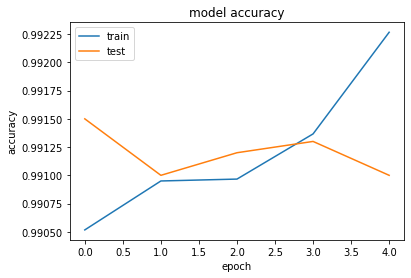

In [18]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Tensorflow

https://www.tensorflow.org/tutorials/estimators/cnn

In [19]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as np

tf.logging.set_verbosity(tf.logging.INFO)

In [20]:
def cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

  # Convolutional Layer #1
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2 and Pooling Layer #2
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Dense Layer
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits Layer
  logits = tf.layers.dense(inputs=dropout, units=10)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])
  }
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [21]:
# Load training and eval data
((train_data, train_labels),
 (eval_data, eval_labels)) = tf.keras.datasets.mnist.load_data()

train_data = train_data/np.float32(255)
train_labels = train_labels.astype(np.int32)  # not required

eval_data = eval_data/np.float32(255)
eval_labels = eval_labels.astype(np.int32)  # not required

In [22]:
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/tmp/mnist_convnet_model")

I0719 23:49:10.610414 4501730752 estimator.py:1790] Using default config.
I0719 23:49:10.632548 4501730752 estimator.py:209] Using config: {'_model_dir': '/tmp/mnist_convnet_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x12cda2908>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [23]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}

logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

In [24]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

# train one step and display the probabilties
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=1,
    hooks=[logging_hook])

W0719 23:49:14.719864 4501730752 deprecation.py:323] From /Users/an/Projects/otus/venv3/lib/python3.6/site-packages/tensorflow/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W0719 23:49:14.774688 4501730752 deprecation.py:323] From /Users/an/Projects/otus/venv3/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/inputs/queues/feeding_queue_runner.py:62: QueueRunner.__init__ (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
W0719 23:49:14.778332 4501730752 deprecation.py:323] From /Users/an/Projects/otus/venv3/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/in

I0719 23:49:18.375169 4501730752 basic_session_run_hooks.py:262] loss = 2.3098614, step = 1
I0719 23:49:18.389902 4501730752 basic_session_run_hooks.py:606] Saving checkpoints for 1 into /tmp/mnist_convnet_model/model.ckpt.
I0719 23:49:18.748517 4501730752 estimator.py:368] Loss for final step: 2.3098614.


In [25]:
mnist_classifier.train(input_fn=train_input_fn, steps=1000)

I0719 23:53:20.791522 4501730752 estimator.py:1145] Calling model_fn.
I0719 23:53:21.161195 4501730752 estimator.py:1147] Done calling model_fn.
I0719 23:53:21.480247 4501730752 basic_session_run_hooks.py:541] Create CheckpointSaverHook.
I0719 23:53:21.674836 4501730752 monitored_session.py:240] Graph was finalized.
W0719 23:53:21.695182 4501730752 deprecation.py:323] From /Users/an/Projects/otus/venv3/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
I0719 23:53:21.699542 4501730752 saver.py:1280] Restoring parameters from /tmp/mnist_convnet_model/model.ckpt-1
W0719 23:53:21.777482 4501730752 deprecation.py:323] From /Users/an/Projects/otus/venv3/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1066: get_checkpoint_mtimes (from tensorflow

In [26]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)

eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

I0719 23:59:04.225167 4501730752 estimator.py:1145] Calling model_fn.
I0719 23:59:04.440371 4501730752 estimator.py:1147] Done calling model_fn.
I0719 23:59:04.498287 4501730752 evaluation.py:255] Starting evaluation at 2019-07-19T23:59:04Z
I0719 23:59:04.662469 4501730752 monitored_session.py:240] Graph was finalized.
I0719 23:59:04.665235 4501730752 saver.py:1280] Restoring parameters from /tmp/mnist_convnet_model/model.ckpt-1001
I0719 23:59:04.755141 4501730752 session_manager.py:500] Running local_init_op.
I0719 23:59:04.779677 4501730752 session_manager.py:502] Done running local_init_op.
I0719 23:59:10.778207 4501730752 evaluation.py:275] Finished evaluation at 2019-07-19-23:59:10
I0719 23:59:10.780288 4501730752 estimator.py:2039] Saving dict for global step 1001: accuracy = 0.7006, global_step = 1001, loss = 1.8802793
I0719 23:59:10.884468 4501730752 estimator.py:2099] Saving 'checkpoint_path' summary for global step 1001: /tmp/mnist_convnet_model/model.ckpt-1001


{'accuracy': 0.7006, 'loss': 1.8802793, 'global_step': 1001}


### Pytorch

In [2]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

Populating the interactive namespace from numpy and matplotlib


In [3]:
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=64,num_workers=1, pin_memory=True)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

0it [00:00, ?it/s]

9920512it [00:07, 1356182.16it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 84476.86it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:03, 539637.01it/s]                             
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 30964.59it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [4]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - Transformed Shape:', train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

/Users/an/Projects/otus/venv3/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - Transformed Shape: torch.Size([28, 60000, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(784, 548)
        self.bc1 = nn.BatchNorm1d(548)
        
        self.fc2 = nn.Linear(548, 252)
        self.bc2 = nn.BatchNorm1d(252)
        
        self.fc3 = nn.Linear(252, 10)
        
        
    def forward(self, x):
        x = x.view((-1, 784))
        h = self.fc1(x)
        h = self.bc1(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.fc2(h)
        h = self.bc2(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.2, training=self.training)
        
        h = self.fc3(h)
        out = F.log_softmax(h)
        return out

model = Model()
#model.cuda() # CUDA!
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# train

model.train()

losses = []
for epoch in range(10):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data), Variable(target)
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.data.item())
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.data.item()), 
                end='')
            
    print()

/Users/an/Projects/otus/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


 Train Epoch: 0 [57664/60000 (96%)]	Loss: 0.059928
 Train Epoch: 1 [57664/60000 (96%)]	Loss: 0.093594
 Train Epoch: 2 [57664/60000 (96%)]	Loss: 0.094557
 Train Epoch: 3 [57664/60000 (96%)]	Loss: 0.020578
 Train Epoch: 4 [32064/60000 (53%)]	Loss: 0.021111

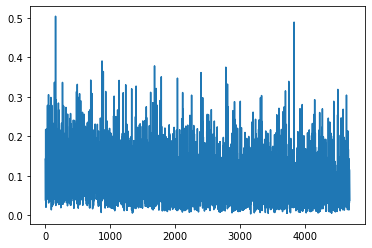

In [44]:
plot(losses)

### Evaluate

In [1]:
evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor())).cuda()
evaluate_y = Variable(test_loader.dataset.test_labels).cuda()


output = model(evaluate_x)
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum()/d.size()[0]

print('Accuracy:', accuracy)
d

NameError: name 'Variable' is not defined

## GPU и нейронные сети
### CPU
- несколько сложных ядер
- оптимизация для выполнения на 1 треде

### GPU
- тысячи простых ядер
- тысячи асинхронных тредов
- оптимизации для операций с float-числами

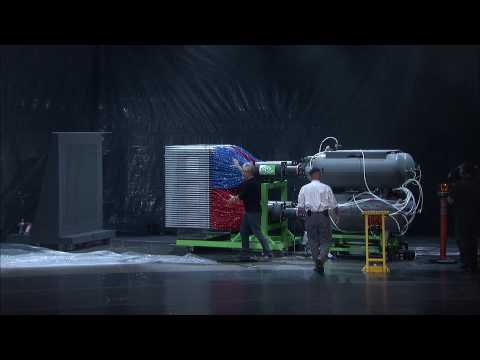

In [8]:
from IPython.display import YouTubeVideo
# a talk about IPython at Sage Days at U. Washington, Seattle.
# Video credit: William Stein.
YouTubeVideo('-P28LKWTzrI')

###  Где найти сервер с GPU:
- Amazon
- google cloud (free trial: 300$)
- google.colab
- kaggle kernels

https://towardsdatascience.com/maximize-your-gpu-dollars-a9133f4e546a

## Обзор задач:
- применение нейронных сетей к картинкам (CNN)
- применение нейронных сетей к последовательностям и текстам (RNN)
- современные архитектуры нейронных сетей

### Опрос в конце лекции
https://forms.gle/cNRwS15sfJG9yADx6

### Дополнительные материалы
https://pytorch.org/docs/stable/index.html  
https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b  
http://keras.io  
https://www.tensorflow.org/api_docs  
https://towardsdatascience.com/maximize-your-gpu-dollars-a9133f4e546a